<a href="https://colab.research.google.com/github/Vinod826S/Vision-Algorithm-for-generation-of-XRD-patterns/blob/main/BTP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

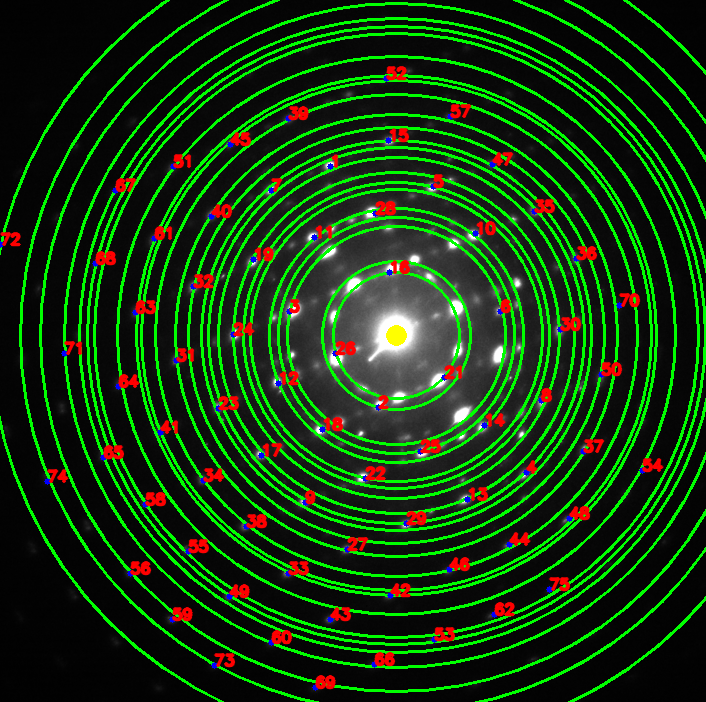

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from google.colab.patches import cv2_imshow
import pandas as pd

def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

image = cv2.imread('/content/BTP_Img_3.png', cv2.IMREAD_GRAYSCALE)
bgr_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Find the coordinates and intensities of all points
coordinates = np.column_stack(np.where(image > 0))
intensities = [image[x, y] for x, y in coordinates]

# Sort coordinates based on intensity
sorted_indices = np.argsort(intensities)[::-1]
sorted_coordinates = [coordinates[i] for i in sorted_indices]

# Take the top 20 points with minimum distance of 50 units
top_coordinates = []
for coord in sorted_coordinates:
    if all(distance(coord, existing_coord) >= 60 for existing_coord in top_coordinates):
        top_coordinates.append(coord)
    if len(top_coordinates) == 75:
        break

points = [(335, 353), (389, 272), (444, 377)]

# Find the center and radius of the circle passing through the points
def find_circle_center_radius(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    ma = (y2 - y1) / (x2 - x1)
    mb = (y3 - y2) / (x3 - x2)
    xc = (ma * mb * (y1 - y3) + mb * (x1 + x2) - ma * (x2 + x3)) / (2 * (mb - ma))
    yc = -1 / ma * (xc - (x1 + x2) / 2) + (y1 + y2) / 2
    radius = np.sqrt((x1 - xc) ** 2 + (y1 - yc) ** 2)
    return (int(xc), int(yc)), int(radius)

# Find the center and radius of the circle passing through the points
center, radius = find_circle_center_radius(points[0], points[1], points[2])

# Draw the center on the image
cv2.circle(bgr_image, center, 5, (0, 255, 255), 10)

point_list = [15, 1, 2, 24, 11, 21, 23, 4, 3, 12, 30, 31, 35, 60, 33, 40, 50, 64, 57, 48, 70, 55, 71, 72]

average_intensities = []

for i in point_list:
    point = tuple(reversed(top_coordinates[i]))
    rad = int(distance(center, point))
    cv2.circle(bgr_image, center, rad, (0,255,0), 2)

    intensities_on_circle = []

    for theta in np.linspace(0, 2*np.pi, 100):
        x_on_circle = int(center[0] + rad * np.cos(theta))
        y_on_circle = int(center[1] + rad * np.sin(theta))
        if 0 <= y_on_circle < image.shape[0] and 0 <= x_on_circle < image.shape[1]:
            intensity = image[y_on_circle, x_on_circle]
            intensities_on_circle.append(intensity)

    # Calculate average intensity for the circle
    average_intensity_circle = np.round(np.mean(intensities_on_circle))
    average_intensities.append(average_intensity_circle)

for i, (x, y) in enumerate(top_coordinates):
    if i != 19:
        cv2.circle(bgr_image, (y, x), 3, (255, 0, 0), -1)  # Small blue dot
        cv2.putText(bgr_image, str(i+1), (y, x), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)

cv2_imshow(bgr_image)

with open('Img3.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Point Number', 'X Coordinate', 'Y Coordinate', 'Intensity', 'Distance', 'Average Intensity'])
    for i, (x, y) in enumerate(top_coordinates):
        if i in point_list:  # Check if the point number is in point_list
            intensity = image[x, y]
            distance_from_center = int(distance(center, (x, y)))
            index = point_list.index(i)
            average_intensity = average_intensities[index] if index < len(average_intensities) else 0
            csvwriter.writerow([i + 1, y, x, intensity, distance_from_center, average_intensity])

data = {}

df = pd.read_csv('/content/Img3.csv')
distance = df['Distance']
avg_intensity = df['Average Intensity']

for d, a in zip(distance, avg_intensity):
    data[d] = a

sorted_data = sorted(data.items(), reverse = True)

# Extract distances and intensities
distances = [d[0] for d in sorted_data]
intensities = [d[1] for d in sorted_data]
distances2 = sorted(distances, reverse = True)

plt.figure(figsize=(10, 6))

plt.plot([0, distances2[0] + 50], [0, 0], color='blue', linestyle='-', linewidth=2)

for distance, intensity in data.items():
    plt.plot([distance, distance], [0, intensity], color='red', linestyle='-', linewidth=2);

plt.xlabel('Distance')
plt.ylabel('Intensity')
plt.title('Average Intensity vs. Distance from the center')
plt.grid(True)
plt.show()